In [2]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import torch as th
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
import re
from enum import Enum

device = th.device("mps") if th.backends.mps.is_available() else th.device("cuda") if th.cuda.is_available() else th.device("cpu")

if device.type == "cuda":
    print(th.cuda.get_device_name(device))
else:
    print(device)

cpu


In [3]:
data_dir = "datasets/"

# Dataset paths
data_original = data_dir + "full/" # Use this for full dataset that contains all review matadata
data_pruned = data_dir + "pruned/" # Only datasets with one number to the right side of it have a pruned version
data_tokenized = data_dir + "tokenized/" # Only datasets with two numbers to the right side of it have a tokenized version

full = "All_Amazon_Review_5" # 80 GB
arts = "Arts_Crafts_and_Sewing" # 518 MB / 629 MB / 1.18 GB
video = "Amazon_Instant_Video_5" # 28 MB
gift = "Gift_Cards_5" # 0.88 MB

In [4]:
class DatasetType(Enum):
    ORIGINAL = 0
    PRUNED = 1
    TOKENIZED = 2

def prune(df: pd.DataFrame | pl.DataFrame) -> pl.DataFrame:
    # list of unwanted summaries in lower case
    summary_filter = ["one star", "two stars", "three stars", "fours stars", "five stars"]
    if isinstance(df, pd.DataFrame):
        df = pl.DataFrame(df.dropna())
    
    assert(isinstance(df, pl.DataFrame))

    df = df.filter(pl.col("summary").apply(str.lower) != "five stars") \
           .filter(pl.col("summary").apply(str.lower) != "four stars") \
           .filter(pl.col("summary").apply(str.lower) != "three stars") \
           .filter(pl.col("summary").apply(str.lower) != "two stars") \
           .filter(pl.col("summary").apply(str.lower) != "one star")
    return df

def write_to_csv(df: pd.DataFrame | pl.DataFrame, path: str) -> None:
    if isinstance(df, pd.DataFrame):
        df.to_csv(path + ".csv", index=False)
    elif isinstance(df, pl.DataFrame):
        df.write_csv(path + ".csv")

def tokenize(df: pl.DataFrame, tokenizer: GPT2Tokenizer) -> pl.DataFrame:
    t = lambda x: tokenizer.encode(x, add_special_tokens=True)
    df = df.lazy().select([
        pl.col("reviewText").apply(t),
        pl.col("summary").apply(t),
        pl.exclude(["reviewText", "summary"])
    ]).collect()
    return df

def load_dataset(dataset: str, dataset_type: DatasetType, keep_cols = ["reviewText", "summary", "overall"]) -> pd.DataFrame | pl.DataFrame:
    if dataset_type == DatasetType.ORIGINAL:
        # return pl.read_json(data_original + dataset + ".json", json_lines=True).select([keep_cols])
        return pd.read_json(data_original + dataset + ".json", lines=True)[keep_cols]
    elif dataset_type == DatasetType.PRUNED:
        return pl.read_csv(data_pruned + dataset + ".csv", dtypes={"reviewtext": pl.Utf8, "summary": pl.Utf8, "overall": pl.Int8})
    elif dataset_type == DatasetType.TOKENIZED:
        df = pl.read_csv(data_tokenized + dataset + ".csv", dtypes={"reviewtext": pl.Utf8, "summary": pl.Utf8, "overall": pl.Int8})
        listify = lambda x: x.split("|")
        df = df.lazy().select([
            pl.col("reviewText").apply(listify).cast(pl.List(pl.Int64)),
            pl.col("summary").apply(listify).cast(pl.List(pl.Int64)),
            pl.exclude(["reviewText", "summary"])
        ]).collect()
        return df

def save_dataset(df: pl.DataFrame, dataset: str, dataset_type: DatasetType) -> None:
    if dataset_type == DatasetType.PRUNED:
        write_to_csv(df, data_pruned + dataset)
    elif dataset_type == DatasetType.TOKENIZED:
        stringify = lambda x: "|".join(list(x.cast(pl.Utf8)))
        df = df.lazy().select([
            pl.col("reviewText").apply(stringify),
            pl.col("summary").apply(stringify),
            pl.exclude(["reviewText", "summary"])
        ]).collect()
        write_to_csv(df, data_tokenized + dataset)

def preprocess(dataset: str, dataset_type: DatasetType, tokenizer, keep_cols = ["reviewText", "summary", "overall"], save_steps=True) -> pd.DataFrame | pl.DataFrame:
    if dataset_type == DatasetType.ORIGINAL:
        df = load_dataset(dataset, dataset_type, keep_cols)
        df = prune(df)
        if save_steps:
            save_dataset(df, dataset, DatasetType.PRUNED)
        df = tokenize(df, tokenizer)
        if save_steps:
            save_dataset(df, dataset, DatasetType.TOKENIZED)
        return df
    elif dataset_type == DatasetType.PRUNED:
        df = load_dataset(dataset, dataset_type)
        df = tokenize(df, tokenizer)
        if save_steps:
            save_dataset(df, dataset, DatasetType.TOKENIZED)
        return df
    elif dataset_type == DatasetType.TOKENIZED:
        df = load_dataset(dataset, dataset_type)
        return df

In [5]:
# Prune and save
df = load_dataset(arts, DatasetType.ORIGINAL)
df = prune(df)
save_dataset(df, arts, DatasetType.PRUNED)

In [5]:
# Tokenize and save
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
df = load_dataset(arts, DatasetType.PRUNED)
print(df["reviewText"][-1])
print(df["summary"][-1])
print(df["overall"][-1])

df = tokenize(df, tokenizer)
print(df.tail())

print("|".join(list(df["reviewText"][0].cast(pl.Utf8))))
save_dataset(df, arts, DatasetType.TOKENIZED)

I received these earlier than expected. Have requested a refund because I received a box of 12 gold markers and I was hoping to receive 12 colors.
One color
1


Token indices sequence length is longer than the specified maximum sequence length for this model (1127 > 1024). Running this sequence through the model will result in indexing errors


shape: (5, 3)
┌─────────────────────────┬───────────────────────┬─────────┐
│ reviewText              ┆ summary               ┆ overall │
│ ---                     ┆ ---                   ┆ ---     │
│ list[i64]               ┆ list[i64]             ┆ i8      │
╞═════════════════════════╪═══════════════════════╪═════════╡
│ [10248, 3081, ... 6930] ┆ [10248, 1988]         ┆ 5       │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [4711, 389, ... 13]     ┆ [4711, 389, ... 6546] ┆ 4       │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [464, 29707, ... 13]    ┆ [986, 1718, ... 13]   ┆ 3       │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [38052, 777, ... 3228]  ┆ [13681, 1720, 3228]   ┆ 5       │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [40, 2722, ... 13]      ┆ [3198, 3124]          ┆ 1       │
└─────────────────────────┴───────────────────────┴─────────┘
40|1053|1100|428|1492|1541|290|314|1053|1392|3352|329|12

In [8]:
# Load the tokenized data
# df = load_dataset(arts, DatasetType.TOKENIZED)
df.tail()

reviewText,summary,overall
list[i64],list[i64],i8
"[10248, 3081, ... 6930]","[10248, 1988]",5
"[4711, 389, ... 13]","[4711, 389, ... 6546]",4
"[464, 29707, ... 13]","[986, 1718, ... 13]",3
"[38052, 777, ... 3228]","[13681, 1720, 3228]",5
"[40, 2722, ... 13]","[3198, 3124]",1


In [12]:
# df = load_dataset(arts, DatasetType.TOKENIZED)

# Find max length of review text with numpy
max_review_len = np.max(list(df['reviewText'].apply(list).apply(len)))
print("\nMax length of review text: ", max_review_len)
# Find max length of summary with numpy
max_summary_len = np.max((list(df['summary'].apply(list).apply(len))))
print("Max length of summary: ", max_summary_len)

TypeError: '>=' not supported between instances of 'int' and 'NoneType'

In [ ]:
# 1535558 has no review tokens
# summary: 1983|4846|317|321|343|29375|10318|282|1689|12|978|32|283|312|71|978|4627|259|993|978|29856|707|86|3301|5598|2623|532|49125|1415|7526|7420|9671
# detokenize, find which data point it in the dataset

ValueError: autodetected range of [nan, nan] is not finite

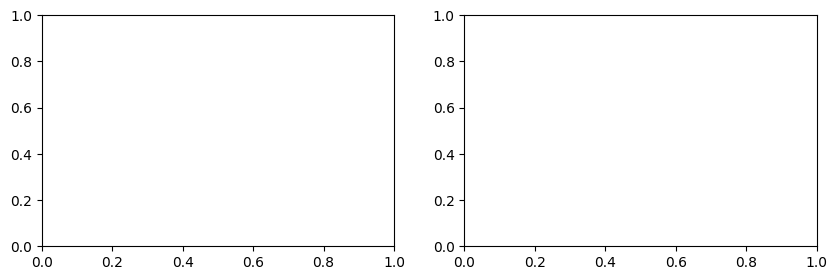

In [13]:
# df = preprocess(arts, DatasetType.ORIGINAL, tokenizer)

# Plot a distribution of review lengths with log scale
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

r_counts, r_bins = np.histogram(df["reviewText"].apply(len), bins=100)
s_counts, s_bins = np.histogram(df["summary"].apply(len), bins=100)

r_vcounts = df["reviewText"].apply(len).value_counts()
s_vcounts = df["summary"].apply(len).value_counts()
r_vbins = list(r_vcounts["reviewText"])
s_vbins = list(s_vcounts["summary"])

log_yscale = True

ax[0].hist(df["reviewText"].apply(len), bins=range(np.min(r_vbins), np.max(r_vbins)), log=log_yscale)
ax[0].set_title("Distribution of review lengths")
ax[0].set_xlabel("Review length")
ax[0].set_ylabel("Frequency")
ax[0].grid()

ax[1].hist(df["summary"].apply(len), bins=range(np.min(s_vbins), np.max(s_vbins)), log=log_yscale)
ax[1].set_title("Distribution of summary lengths")
ax[1].set_xlabel("summary length")
ax[1].set_ylabel("Frequency")
ax[1].grid()

plt.show()

In [4]:
# torch dataset from pandas dataframe
# defines a voacbulary of words and converts the review text to a list of indices
# beware of symbols like ., !, ? etc.
# pad the review text and summary to max_review_len and max_summary_len respectively

class ReviewDataset(th.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df.iloc[idx, 0].split()
        review = [self.vocab2idx[word] for word in review]
        review = th.tensor(review, dtype=th.long)
        review = th.nn.functional.pad(review, (0, max_review_len - len(review)))
        rating = self.df.iloc[idx, 1]
        rating = th.tensor(rating, dtype=th.long)
        summary = self.df.iloc[idx, 2].split()
        summary = [self.vocab2idx[word] for word in summary]
        summary = th.tensor(summary, dtype=th.long)
        summary = th.nn.functional.pad(summary, (0, max_summary_len - len(summary)))

        # move tensors to device
        review = review.to(device)
        rating = rating.to(device)
        summary = summary.to(device)
        
        return review, rating, summary

In [6]:
# torch dataset from pandas dataframe
# defines a voacbulary of words and converts the review text to a list of indices

In [8]:
# test the dataset
dataset = ReviewDataset(df)
print(dataset[0])

TypeError: new(): invalid data type 'str'

In [ ]:
"""
Model
uses context aware word embedding
multi-task network

Input: takes in a review string
Task 1: output a summary string of the input review with a max length defined by the dataset
Task 2: output a rating of the input review as a float 0-1

Use an encoder decoder setup with one decoder for each task
"""
class Summariser(th.nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_review_len, max_summary_len):
        super(Summariser, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_review_len = max_review_len
        self.max_summary_len = max_summary_len
        self.embedding = th.nn.Embedding(vocab_size, embedding_dim)
        self.encoder = th.nn.LSTM(embedding_dim, embedding_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.decoder1 = th.nn.LSTM(embedding_dim, embedding_dim, num_layers=2, batch_first=True)
        self.decoder2 = th.nn.LSTM(embedding_dim, embedding_dim, num_layers=2, batch_first=True)
        self.linear1 = th.nn.Linear(embedding_dim, vocab_size)
        self.linear2 = th.nn.Linear(embedding_dim, 1)
        self.softmax = th.nn.Softmax(dim=2)
        self.sigmoid = th.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.encoder(x)
        x1, _ = self.decoder1(x)
        x2, _ = self.decoder2(x)
        x1 = self.linear1(x1)
        x1 = self.softmax(x1)
        x2 = self.linear2(x2)
        x2 = self.sigmoid(x2)
        return x1, x2

In [ ]:
"""
Dataset preparation
Use the ReviewDataset to create a DataLoader
Splitting the train, validation, and test sets
"""
# initialise the dataset
dataset = ReviewDataset(df)
dataset_size = len(dataset)

# shrink dataset for testing
dataset_size = 500
dataset = th.utils.data.Subset(dataset, range(dataset_size))

# split the dataset
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = th.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create the dataloaders
batch_size = 32
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = th.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# test the dataloader
train_loader_iter = iter(train_loader)
x, y, z = next(train_loader_iter)
print(x.shape, y.shape, z.shape)


torch.Size([32, 18152]) torch.Size([32]) torch.Size([32, 151])


In [ ]:
"""
Training
"""
""" # initialise the model
# take into account if it is a subset of the dataset
model = Summariser(dataset.dataset.vocab_size, 256, max_review_len, max_summary_len)
model = model.to(device)

# define the loss functions
loss_fn1 = th.nn.CrossEntropyLoss()
loss_fn2 = th.nn.BCELoss()

# define the optimiser
optimiser = th.optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
epochs = 10

# train the model
for epoch in range(epochs):
    for review, rating, summary in train_loader:
        # zero the gradients
        optimiser.zero_grad()

        # forward pass
        y_pred1, y_pred2 = model(review)

        # calculate the loss
        loss1 = loss_fn1(y_pred1, summary)
        loss2 = loss_fn2(y_pred2, rating.unsqueeze(1).float())
        loss = loss1 + loss2

        # backward pass
        loss.backward()

        # update the weights
        optimiser.step()

    # print the loss
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}') """
